In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [134]:
# Step 1: Load and merge data

# Load gene expression and dependency data
expression_data = pd.read_csv('Batch_corrected_Expression_Public_24Q2_subsetted_with_CCLE1.csv')  # replace with actual filename
dependency_data = pd.read_csv('CRISPRGeneDependency_with_CCLE_ScreenID3.csv')  # replace with actual filename

# Merge on 'CCLEName' and 'ModelID' to align rows
#merged_df = gene_expression_df.join(gene_dependency_df.set_index('ModelID'), on='ModelID')
#df.join(gene_expression_df, gene_dependency_df, on =['CCLEName','ModelID'], how='inner')

# Clean up column names by stripping any leading or trailing spaces
dependency_data.columns = dependency_data.columns.str.strip()
expression_data.columns = expression_data.columns.str.strip()

# Set 'CCLEName' and 'ModelID' as the index for both dataframes
dependency_data.set_index(['CCLEName', 'ModelID'], inplace=True)
expression_data.set_index(['CCLEName', 'ModelID'], inplace=True)

# Use join to merge on index with suffixes to handle overlapping columns
merged_data = expression_data.join(dependency_data, how='left', lsuffix='_expr', rsuffix='_dep')

# Reset index if you want 'CCLEName' and 'ModelID' as columns again
merged_data.reset_index(inplace=True)


In [140]:
merged_data.shape


(1588, 16909)

In [142]:
missing_in_expression = set(dependency_data.columns) - set(expression_data.columns)
missing_in_dependency = set(gene_expression_df.columns) - set(gene_dependency_df.columns)
print("Genes in dependency but not in expression:", missing_in_expression)


Genes in dependency but not in expression: {'CDH1', 'IRS2', 'SLC7A5', 'HDAC3', 'FOSL1', 'SHOC2', 'MBTPS1', 'CUL3', 'MED23', 'MARS2', 'NUP153', 'NUP93', 'BCLAF1', 'LAGE3', 'SPRTN', 'GMPS', 'PMPCB', 'PRKRA', 'SNAP23', 'CDC42', 'CCND2', 'CDC25B', 'RNMT', 'TAF1C', 'FUBP1', 'HGS', 'KNTC1', 'FAM50A', 'RAE1', 'TAF1A', 'CDS2', 'NCAPD2', 'PPM1D', 'CTR9', 'EIF3J', 'CHMP7', 'CIAO1', 'GRWD1', 'SLC25A28', 'RTN4IP1', 'OGT', 'LONP1', 'IPO13', 'GTF3C5', 'TAF1B', 'SOCS3', 'RAB1B', 'ATP6V0E1', 'MED24', 'MFN2', 'GGPS1', 'DHX38', 'KIF18A', 'RBM39', 'PNPT1', 'COG8', 'KLF4', 'CFLAR', 'CCNE1', 'SLC4A7', 'AIFM1', 'CCNA2', 'EDF1', 'MED12', 'MED26', 'ATP6V1G1', 'KIF14', 'LDB1', 'CCNC', 'PPIL4', 'PTTG1', 'ARHGEF7'}


In [143]:
missing_columns = set(dependency_data.columns) - set(merged_data.columns)
print("Missing columns:", missing_columns)

Missing columns: {'PTBP1', 'DDX3X', 'ACIN1', 'TAF1', 'OGDH', 'DLD', 'ATP6V1C1', 'SCAP', 'BCL2L1', 'NDUFS2', 'INTS6', 'PNN', 'ADSL', 'SLC2A1', 'CAD', 'TBP', 'PELP1', 'ACLY', 'COPG1', 'PELO', 'GTF3C1', 'MYCN', 'MRPS34', 'RNPC3', 'NKX2-1', 'RAD51C', 'RPL22L1', 'HDAC1', 'SEPHS2', 'TFDP1', 'PDS5A', 'STAG1', 'EXOSC8', 'CEP192', 'PSMG3', 'RTCB', 'TAMM41', 'MYBBP1A', 'DDX39A', 'SMG6', 'PARS2', 'RINT1', 'SMAD7', 'NRBP1', 'RFC2', 'ELAC2', 'IRF8', 'DHPS', 'BMPR1A', 'TBCD', 'POLRMT', 'NHLRC2', 'PDCD11', 'RPN1', 'FANCD2', 'PITRM1', 'MIS12', 'RNF20', 'RAC1', 'CEP55', 'SYVN1', 'PPP1R8', 'COQ4', 'SLC39A10', 'FZD5', 'MIOS', 'NUP98', 'NDUFB7', 'SARS2', 'MET', 'AHCYL1', 'AP2M1', 'SRSF6', 'DNAJC9', 'IPO11', 'NCKAP1', 'SLC38A2', 'EFR3A', 'TBX3', 'EMC7', 'LENG1', 'CSTF2', 'RBM28', 'NDC1', 'MMS19', 'CSNK2A1', 'ILK', 'FURIN', 'CDC37', 'SKA3', 'PFDN5', 'ARGLU1', 'ITGB5', 'FAU', 'SDHB', 'EXOSC9', 'MRPS22', 'ALG1', 'SPAG5', 'METAP2', 'IGF1R', 'PTPN23', 'DCTN3', 'POLR3E', 'STAG2', 'NONO', 'ARIH1', 'PPAT', 'NDUFS3

In [144]:
# After merging, separate features (gene expression) and targets (dependency scores)
expression_data = merged_data.filter(regex='^(?!CCLEName|ModelID)')  # all columns except CCLEName and ModelID
#dependency_data = merged_df[gene_dependency_df.columns.difference(['CCLEName', 'ModelID'])]  # only dependency scores
#dependency_data = merged_df.filter(items=gene_dependency_df.columns.difference(['CCLEName', 'ModelID']))
dependency_data = merged_data.filter(items=gene_dependency_df.columns.difference(['CCLEName', 'ModelID']))


In [145]:
# Check the shapes to confirm they match
print("Expression data shape:", expression_data.shape)
print("Dependency data shape:", dependency_data.shape)


Expression data shape: (1588, 16907)
Dependency data shape: (1588, 72)


In [39]:
# Now, split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(expression_data, dependency_data, test_size=0.2, random_state=42)

In [40]:
# Standardize features (important for neural network training)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
# Step 3: Build the Model

# Define a simple feedforward neural network
model = Sequential([
    Dense(576, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(288, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(144, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(72, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(y_train.shape[1], activation='linear')  # Output layer with linear activation
])
# Compile the model
optimizer = Adam(learning_rate=0.001)  # Starting learning rate
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

C:\Users\Nilabja\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
# Step 4: Train the Model

# Train the model with early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 3.6477 - mae: 1.0593 - val_loss: 5.5819 - val_mae: 1.4189 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 3.1130 - mae: 0.8482 - val_loss: 3.1528 - val_mae: 0.8904 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 2.6009 - mae: 0.7173 - val_loss: 2.2966 - val_mae: 0.6661 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 2.1864 - mae: 0.6267 - val_loss: 1.8054 - val_mae: 0.5215 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 1.8289 - mae: 0.5442 - val_loss: 1.4527 - val_mae: 0.4071 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 1.5324 - mae: 0.4666 - val_loss: 1.1826 - val_mae: 0.3115 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 1.2757 - mae: 0.3961 - val_loss: 0.9870 - val_mae: 0.2424 - learning_rate: 0.0010
E

In [54]:
# Step 5: Evaluate the Model

# Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0551 - mae: 0.1530
Test MAE: 0.15272676944732666


In [56]:
# Step 6: Make Predictions

# Example of making predictions on test data
predictions = model.predict(X_test)

# Optional: Inspecting Results
# Convert predictions and actuals to a DataFrame for easy comparison
results_df = pd.DataFrame({
    'Actual': y_test.values.flatten(),
    'Predicted': predictions.flatten()
})

print(results_df.head())

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
     Actual  Predicted
0  0.207460   0.328185
1  0.161307   0.238607
2  0.120503   0.098714
3  0.960763   0.860810
4  0.964577   0.586475


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


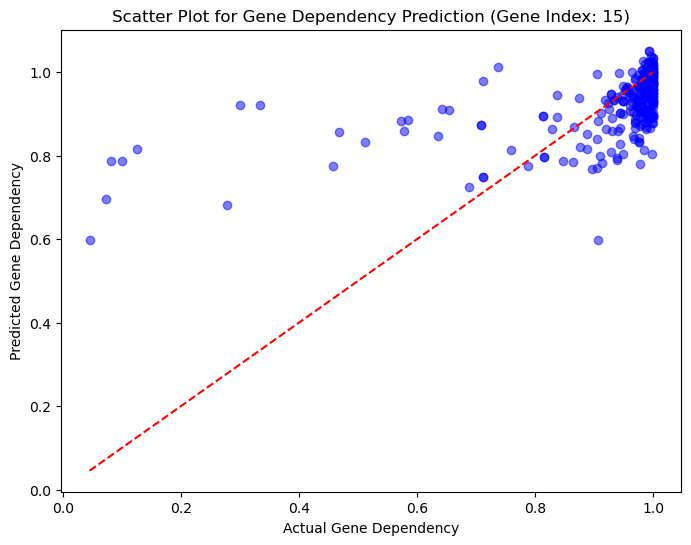

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get model predictions
y_pred = model.predict(X_test)

# Ensure y_test and y_pred are arrays for easier slicing
y_test = y_test.values if isinstance(y_test, pd.DataFrame) else y_test
y_pred = y_pred if isinstance(y_pred, np.ndarray) else np.array(y_pred)

# Step 2: Select a specific gene index
gene_index = 15  # Change this index to select a specific gene for plotting
y_test_gene = y_test[:, gene_index]  # Actual dependency scores for the selected gene
y_pred_gene = y_pred[:, gene_index]  # Predicted dependency scores for the selected gene

# Step 3: Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_gene, y_pred_gene, alpha=0.5, color='blue')
plt.plot([min(y_test_gene), max(y_test_gene)], [min(y_test_gene), max(y_test_gene)], 'r--')  # Diagonal reference line
plt.xlabel("Actual Gene Dependency")
plt.ylabel("Predicted Gene Dependency")
plt.title(f"Scatter Plot for Gene Dependency Prediction (Gene Index: {gene_index})")
plt.show()


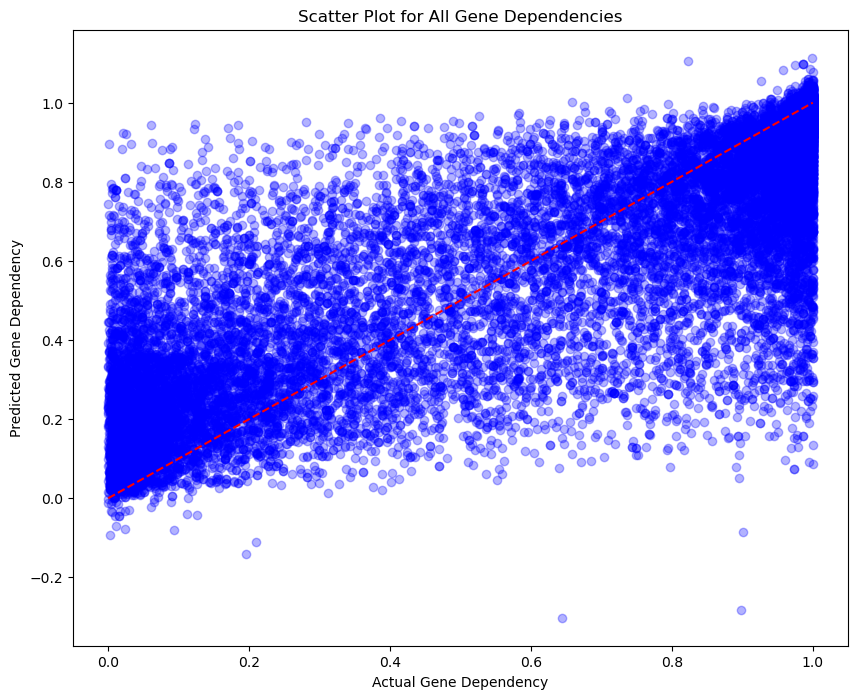

In [74]:

# Step 1: Flatten y_test and y_pred to have all genes in one dimension
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Step 2: Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test_flat, y_pred_flat, alpha=0.3, color='blue')
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], 'r--')  # Diagonal reference line
plt.xlabel("Actual Gene Dependency")
plt.ylabel("Predicted Gene Dependency")
plt.title("Scatter Plot for All Gene Dependencies")

# Display the plot
plt.show()
